In [148]:
import torch
from collections import (
    namedtuple,
    OrderedDict,
)

torch.set_printoptions(precision=2, sci_mode=False)

def left_neighbors(sides,  size):
    neighbors = ['back', 'front', 'top', 'down']
    l, r, t, d = [sides[n] for n in neighbors]    
    return [
        l[:size, :, :],
        r[:size, :, :],
        t[:, :size, :],
        d[:, :size, :],
    ]

def right_neighbors(sides,  size):
    neighbors = ['front', 'back', 'top', 'down']
    l, r, t, d = [sides[n] for n in neighbors]    
    return [
        l[-size:, :, :],
        r[-size:, :, :],
        t[:, -size:, :],
        d[:, -size:, :],
    ]

def front_neighbors(sides,  size):
    neighbors = ['left', 'right', 'top', 'down']
    l, r, t, d = [sides[n] for n in neighbors]    
    return [
        l[-size:, :, :],
        r[-size:, :, :],
        t[-size:, :, :],
        d[-size:, :, :],
    ]

def back_neighbors(sides,  size):
    neighbors = ['right', 'left', 'top', 'down']
    l, r, t, d = [sides[n] for n in neighbors]    
    return [
        l[:size, :, :],
        r[:size, :, :],
        t[:size, :, :],
        d[:size, :, :],
    ]

def top_neighbors(sides,  size):
    neighbors = ['left', 'right', 'back', 'front']
    l, r, t, d = [sides[n] for n in neighbors]    
    return [
        l[:, -size:, :],
        r[:, -size:, :],
        t[:, -size:, :],
        d[:, -size:, :],
    ]

def down_neighbors(sides,  size):
    neighbors = ['left', 'right', 'front', 'back']
    l, r, t, d = [sides[n] for n in neighbors]    
    return [
        l[:, :size, :],
        r[:, :size, :],
        t[:, :size, :],
        d[:, :size, :],        
    ]


def get_neighbors(sides,  side_name, size):
    if side_name == 'left':
        return left_neighbors(sides,  size)
    elif side_name == 'right':
        return right_neighbors(sides,  size)
    elif side_name == 'front':
        return front_neighbors(sides,  size)
    elif side_name == 'back':
        return back_neighbors(sides,  size)
    elif side_name == 'top':
        return top_neighbors(sides,  size)
    elif side_name == 'down':
        return down_neighbors(sides,  size)
    raise Exception(f'Unknown side name {side}')
    
def make_tris(size, device):
    tl = torch.triu(torch.ones(size, size)) - (torch.eye(size) * 0.5)
    dr = torch.tril(torch.ones(size, size)) - (torch.eye(size) * 0.5)    
    tl, dr = tl.to(device), dr.to(device)
    res = {
        'tl': tl[:,:,None],
        'lt': tl.t().clone()[:,:,None],        
        'tr': tl.t().flip(dims=(0,)).t()[:,:,None],
        'rt': tl.flip(dims=(0,)).t()[:,:,None],
        'dr': dr.t()[:,:,None],
        'rd': dr[:,:,None],
        'ld': dr.flip(dims=(0,)).t()[:,:,None],
        'dl': dr.t().flip(dims=(0,)).t()[:,:,None],      
    }
#     for k in res:
#         res[k]=  torch.ones_like(res[k])
    return res

def front_corners(size, l, r, t, d):
    tris = make_tris(size, l.device)
    lt = l[:, -size:, :]
    tl = t[:, :size, :] 

    tr = t[:, -size:, :]
    rt = r[:, -size:, :] 

    ld = l[:, :size, :] 
    dl = d[:, :size, :]

    rd = r[:, :size, :]
    dr = d[:, -size:, :]

    ltc = lt * tris['lt'] + tl * tris['tl']
    trc = tr * tris['tr'] + rt * tris['rt']
    ldc = ld * tris['ld'] + dl * tris['dl'] 
    drc = dr * tris['rd'] + rd * tris['dr']
    
    return ltc, trc, ldc, drc

def back_corners(size, l, r, t, d):
    tris = make_tris(size, l.device)
    lt = l[:, -size:, :]
    tl = t[:, -size:, :] 

    tr = t[:, :size, :]
    rt = r[:, -size:, :] 

    ld = l[:, :size, :] 
    dl = d[:, -size:, :]

    rd = r[:, :size, :]
    dr = d[:, :size, :]

    ltc = lt * tris['lt'] + tl * tris['tl']
    trc = tr * tris['tr'] + rt * tris['rt']
    ldc = ld * tris['ld'] + dl * tris['dl'] 
    drc = dr * tris['rd'] + rd * tris['dr']
    
    return ltc, trc, ldc, drc


def get_corners(size, side_name, l, r, t, d):
    if side_name == 'front':
        return front_corners(size, l, r, t, d)
    elif side_name == 'back':
        return back_corners(size, l, r, t, d)
    raise Exception(f'Unknown side name {side_name}')
    

def pad_side(sides, side_name, kernel_size):
    o = sides[side_name]
    size = (kernel_size - 1) // 2
    l, r, t, d = get_neighbors(sides, side_name, size)
    lt, tr, ld, dr = get_corners(size, l, r, t, d)

    top = torch.cat((lt, t, tr), dim=1).permute(1, 0, 2)
    down = torch.cat((ld, d, dr), dim=1).permute(1, 0, 2)
    middle = torch.cat((l, o, r), dim=0)
    
    return torch.cat((top, middle, down), dim=0)

In [23]:
n, start, end = 7, -0.5, 0.5

def shape(*args):
    return [f.shape for f in args]

device = torch.device('cuda')
d1, d2 = torch.meshgrid(
    torch.linspace(start, end, steps=n),
    torch.linspace(start, end, steps=n))
d1, d2 = d1.to(device), d2.to(device)

d3 = torch.full_like(d1, end) + 1 / n
sides =  OrderedDict({
    'front': torch.stack((+d3,  d1,  d2), dim=-1),
    'right': torch.stack(( d1, +d3,  d2), dim=-1),    
    'back' : torch.stack((-d3,  d1,  d2), dim=-1),         
    'left' : torch.stack(( d1, -d3,  d2), dim=-1),
    'top'  : torch.stack(( d1,  d2, +d3), dim=-1),
    'down' : torch.stack(( d1,  d2, -d3), dim=-1),
})
sides.keys()

shape(d1, d2, d3)

[torch.Size([7, 7]), torch.Size([7, 7]), torch.Size([7, 7])]

In [36]:
side_name, kernel_size = 'front', 3

o = sides[side_name]
size = (kernel_size - 1) // 2
l, r, t, d = get_neighbors(sides, side_name, size)
lt, tr, ld, dr = get_corners(size, l, r, t, d)

top = torch.cat((lt, t, tr), dim=1).permute(1, 0, 2)

down = torch.cat((ld, d, dr), dim=1).permute(1, 0, 2)

middle = torch.cat((l, o, r), dim=0)

padded = torch.cat((top, middle, down), dim=1)
padded.shape

torch.Size([9, 9, 3])

<IPython.core.display.Javascript object>


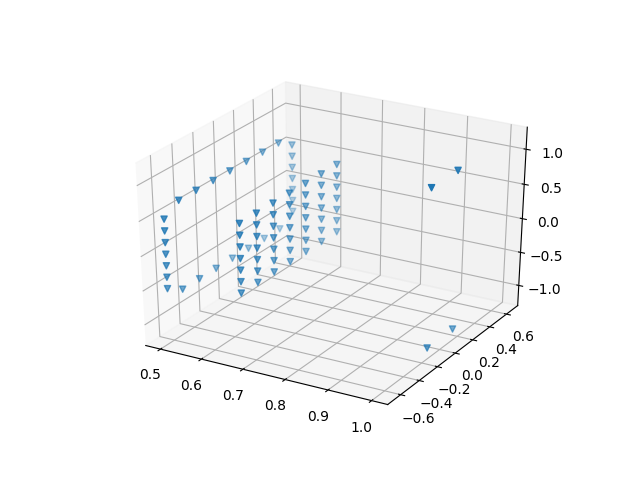

[(81,), (81,), (81,)]


In [37]:
%matplotlib notebook


import matplotlib.pyplot as plt
import numpy as np

def plot(ax, t, m):
    t = t.cpu().numpy()
    xs = t[:, :, 0].flatten()
    ys = t[:, :, 1].flatten()
    zs = t[:, :, 2].flatten()
    print([x.shape for x in [xs, ys, zs]])
    ax.scatter(xs, ys, zs, marker=m)    

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plot(ax, padded, 'v')

[torch.Size([1, 1, 3]), torch.Size([1, 1, 3]), torch.Size([1, 1, 3]), torch.Size([1, 1, 3])]


<IPython.core.display.Javascript object>


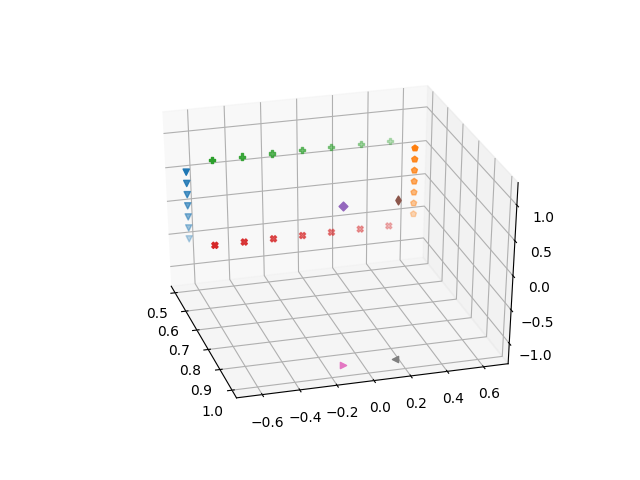

[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]


In [38]:
o = sides[side_name]
size = (kernel_size - 1) // 2
l, r, t, d = get_neighbors(sides, side_name, size)
lt, tr, ld, dr = get_corners(size, l, r, t, d)
print(shape(lt, tr, ld, dr ))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#plot(ax, o, '8')

plot(ax, l, 'v')
plot(ax, r, 'p')
plot(ax, t, 'P')
plot(ax, d, 'X')

plot(ax, lt, 'D')
plot(ax, tr, 'd')
plot(ax, ld, '>')
plot(ax, dr, '<')

[torch.Size([1, 7, 3]), torch.Size([1, 7, 3]), torch.Size([1, 7, 3]), torch.Size([1, 7, 3])]


<IPython.core.display.Javascript object>


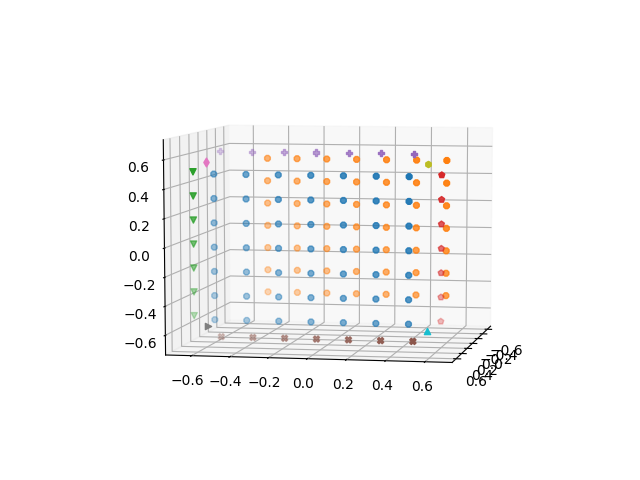

[(49,), (49,), (49,)]
[(49,), (49,), (49,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]


In [114]:
side_name = 'front'
kernel_size = 3
o = sides[side_name]
op = sides['back']
size = (kernel_size - 1) // 2
l, r, t, d = get_neighbors(sides, side_name, size)
print(shape(l, r, t, d ))

tris = make_tris(size, l.device)
lt = l[:, -size:, :]
tl = t[:, :size, :] 

tr = t[:, -size:, :]
rt = r[:, -size:, :] 

ld = l[:, :size, :] 
dl = d[:, :size, :]

rd = r[:, :size, :]
dr = d[:, -size:, :]

ltc = lt * tris['lt'] + tl * tris['tl']
trc = tr * tris['tr'] + rt * tris['rt']
ldc = ld * tris['ld'] + dl * tris['dl'] 
drc = dr * tris['rd'] + rd * tris['dr']

ltc, trc, ldc, drc = get_corners(size, side_name, l, r, t, d) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plot(ax, o, '8')
plot(ax, op, '8')

plot(ax, l, 'v')
plot(ax, r, 'p')
plot(ax, t, 'P')
plot(ax, d, 'X')

#plot(ax, lt, 'd')
#plot(ax, tl, 'd')
plot(ax, ltc, 'd')


# plot(ax, ld, '>')
# plot(ax, dl, '>')
plot(ax, ldc, '>')

# plot(ax, tr, 'h')
# plot(ax, rt, 'h')
plot(ax, trc, 'h')

# plot(ax, dr, '^')
# plot(ax, rd, '^')
plot(ax, drc, '^')

[torch.Size([3, 7, 3]), torch.Size([3, 7, 3]), torch.Size([7, 3, 3]), torch.Size([7, 3, 3])]


<IPython.core.display.Javascript object>


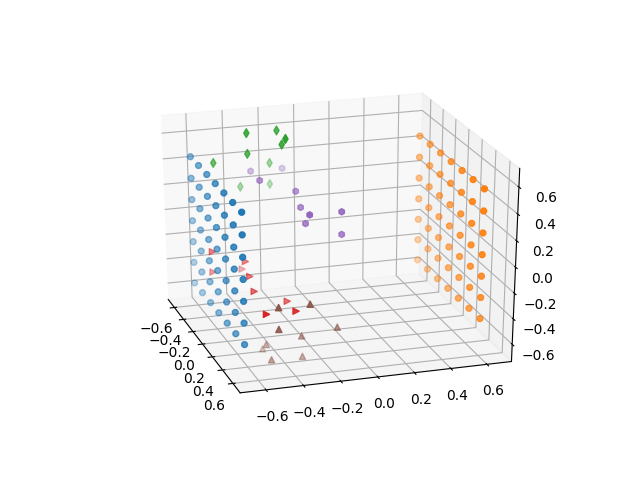

[(49,), (49,), (49,)]
[(49,), (49,), (49,)]
[(9,), (9,), (9,)]
[(9,), (9,), (9,)]
[(9,), (9,), (9,)]
[(9,), (9,), (9,)]


In [189]:
def left_corners(size, l, r, t, d):
    tris = make_tris(size, l.device)
    lt = l[:, -size:, :]
    tl = t[:size, :,  :] 

    ld = l[:, :size, :] 
    dl = d[:size, :, :]


    tr = t[-size:,:,  :]
    rt = r[:,-size:, :] 


    rd = r[:, :size, :]
    dr = d[-size:,:,  :]

    ltc = lt * tris['lt'] + tl * tris['tl']
    trc = tr * tris['tr'] + rt * tris['rt']
    ldc = ld * tris['ld'] + dl * tris['dl'] 
    drc = dr * tris['rd'] + rd * tris['dr']
    
    return ltc, trc, ldc, drc


def get_corners(size, side_name, l, r, t, d):
    if side_name == 'front':
        return front_corners(size, l, r, t, d)
    elif side_name == 'back':
        return back_corners(size, l, r, t, d)
    elif side_name == 'left':
        return left_corners(size, l, r, t, d)
    raise Exception(f'Unknown side name {side_name}')
    
side_name = 'left'
kernel_size = 7
o = sides[side_name]
op = sides['right']
size = (kernel_size - 1) // 2
l, r, t, d = get_neighbors(sides, side_name, size)
print(shape(l, r, t, d ))

tris = make_tris(size, l.device)
lt = l[:, -size:, :]
tl = t[:size, :,  :] 

ld = l[:, :size, :] 
dl = d[:size, :, :]


tr = t[-size:,:,  :]
rt = r[:,-size:, :] 


rd = r[:, :size, :]
dr = d[-size:,:,  :]

ltc = lt * tris['lt'] + tl * tris['tl']
trc = tr * tris['tr'] + rt * tris['rt']
ldc = ld * tris['ld'] + dl * tris['dl'] 
drc = dr * tris['rd'] + rd * tris['dr']

ltc, trc, ldc, drc = get_corners(size, side_name, l, r, t, d) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plot(ax, o, '8')
plot(ax, op, '8')

# plot(ax, l, 'v')
# plot(ax, r, 'p')
# plot(ax, t, 'P')
# plot(ax, d, 'X')

# plot(ax, lt, 'd')
# plot(ax, tl, 'd')
plot(ax, ltc, 'd')


# plot(ax, ld, '>')
# plot(ax, dl, '>')
plot(ax, ldc, '>')

# plot(ax, tr, 'h')
# plot(ax, rt, 'h')
plot(ax, trc, 'h')

# plot(ax, dr, '^')
# plot(ax, rd, '^')
plot(ax, drc, '^')

[torch.Size([1, 7, 3]), torch.Size([1, 7, 3]), torch.Size([7, 1, 3]), torch.Size([7, 1, 3])]


<IPython.core.display.Javascript object>


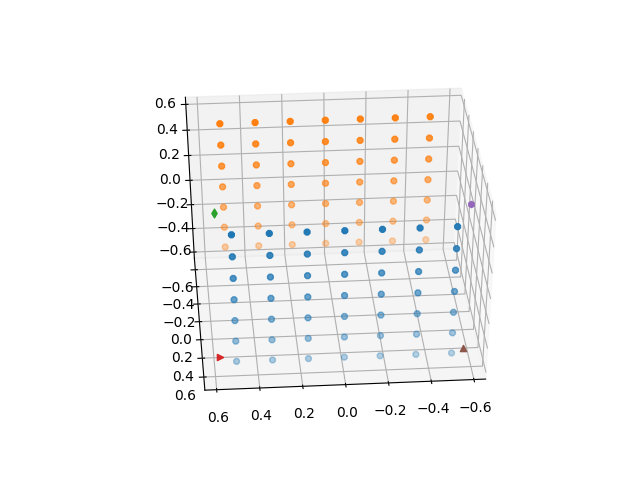

[(49,), (49,), (49,)]
[(49,), (49,), (49,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]


In [224]:
def right_corners(size, l, r, t, d):
    tris = make_tris(size, l.device)
    lt = l[:, -size:, :]
    tl = t[-size:, :,  :] 

    ld = l[:, :size, :] 
    dl = d[-size:, :, :]

    tr = t[:size,:,  :]
    rt = r[:,-size:, :] 
    
    rd = r[:, :size, :]
    dr = d[:size,:,  :]
    
    ltc = lt * tris['lt'] + tl * tris['tl']
    trc = tr * tris['tr'] + rt * tris['rt']
    ldc = ld * tris['ld'] + dl * tris['dl'] 
    drc = dr * tris['rd'] + rd * tris['dr']
    
    return ltc, trc, ldc, drc


def get_corners(size, side_name, l, r, t, d):
    if side_name == 'front':
        return front_corners(size, l, r, t, d)
    elif side_name == 'back':
        return back_corners(size, l, r, t, d)
    elif side_name == 'left':
        return left_corners(size, l, r, t, d)
    elif side_name == 'right':
        return right_corners(size, l, r, t, d)
    raise Exception(f'Unknown side name {side_name}')
    
side_name = 'right'
kernel_size = 3
o = sides[side_name]
op = sides['left']
size = (kernel_size - 1) // 2
l, r, t, d = get_neighbors(sides, side_name, size)
print(shape(l, r, t, d ))

tris = make_tris(size, l.device)
lt = l[:, -size:, :]
tl = t[-size:, :,  :] 

ld = l[:, :size, :] 
dl = d[-size:, :, :]


tr = t[:size,:,  :]
rt = r[:,-size:, :] 


rd = r[:, :size, :]
dr = d[:size,:,  :]

ltc = lt * tris['lt'] + tl * tris['tl']
trc = tr * tris['tr'] + rt * tris['rt']
ldc = ld * tris['ld'] + dl * tris['dl'] 
drc = dr * tris['rd'] + rd * tris['dr']

ltc, trc, ldc, drc = get_corners(size, side_name, l, r, t, d) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plot(ax, o, '8')
plot(ax, op, '8')

# plot(ax, l, 'v')
# plot(ax, r, 'p')
# plot(ax, t, 'P')
# plot(ax, d, 'X')

# plot(ax, lt, 'd')
# plot(ax, tl, 'd')
plot(ax, ltc, 'd')


# plot(ax, ld, '>')
# plot(ax, dl, '>')
plot(ax, ldc, '>')

# plot(ax, tr, 'h')
# plot(ax, rt, 'h')
plot(ax, trc, 'h')

# plot(ax, dr, '^')
# plot(ax, rd, '^')
plot(ax, drc, '^')

[torch.Size([7, 1, 3]), torch.Size([7, 1, 3]), torch.Size([7, 1, 3]), torch.Size([7, 1, 3])]


<IPython.core.display.Javascript object>


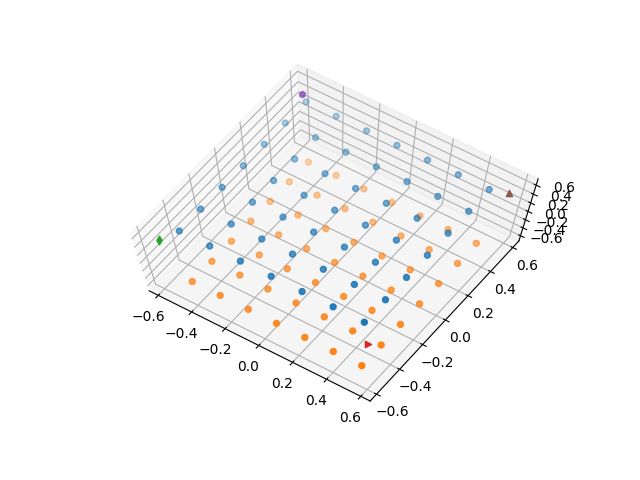

[(49,), (49,), (49,)]
[(49,), (49,), (49,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]


In [258]:
def top_corners(size, l, r, t, d):
    tris = make_tris(size, l.device)
    lt = l[:size,:,  :]
    tl = t[:size, :,  :] 

    ld = l[-size:,:,  :] 
    dl = d[:size, :, :]


    tr = t[-size:, :,  :]
    rt = r[:size,:, :] 


    rd = r[-size:,:,  :]
    dr = d[-size:,:,  :]
    
    ltc = lt * tris['lt'] + tl * tris['tl']
    trc = tr * tris['tr'] + rt * tris['rt']
    ldc = ld * tris['ld'] + dl * tris['dl'] 
    drc = dr * tris['rd'] + rd * tris['dr']
    
    return ltc, trc, ldc, drc


def get_corners(size, side_name, l, r, t, d):
    if side_name == 'front':
        return front_corners(size, l, r, t, d)
    elif side_name == 'back':
        return back_corners(size, l, r, t, d)
    elif side_name == 'left':
        return left_corners(size, l, r, t, d)
    elif side_name == 'right':
        return right_corners(size, l, r, t, d)
    elif side_name == 'top':
        return top_corners(size, l, r, t, d)
    raise Exception(f'Unknown side name {side_name}')
    
side_name = 'top'
kernel_size = 3
o = sides[side_name]
op = sides['down']
size = (kernel_size - 1) // 2
l, r, t, d = get_neighbors(sides, side_name, size)
print(shape(l, r, t, d ))

tris = make_tris(size, l.device)
lt = l[:size,:,  :]
tl = t[:size, :,  :] 

ld = l[-size:,:,  :] 
dl = d[:size, :, :]


tr = t[-size:, :,  :]
rt = r[:size,:, :] 


rd = r[-size:,:,  :]
dr = d[-size:,:,  :]

ltc = lt * tris['lt'] + tl * tris['tl']
trc = tr * tris['tr'] + rt * tris['rt']
ldc = ld * tris['ld'] + dl * tris['dl'] 
drc = dr * tris['rd'] + rd * tris['dr']

ltc, trc, ldc, drc = get_corners(size, side_name, l, r, t, d) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plot(ax, o, '8')
plot(ax, op, '8')

# plot(ax, l, 'v')
# plot(ax, r, 'p')
# plot(ax, t, 'P')
#plot(ax, d, 'X')

# plot(ax, lt, 'd')
# plot(ax, tl, 'd')
plot(ax, ltc, 'd')


# plot(ax, ld, '>')
# plot(ax, dl, '>')
plot(ax, ldc, '>')

# plot(ax, tr, 'h')
# plot(ax, rt, 'h')
plot(ax, trc, 'h')

# plot(ax, dr, '^')
# plot(ax, rd, '^')
plot(ax, drc, '^')

[torch.Size([7, 1, 3]), torch.Size([7, 1, 3]), torch.Size([7, 1, 3]), torch.Size([7, 1, 3])]


<IPython.core.display.Javascript object>


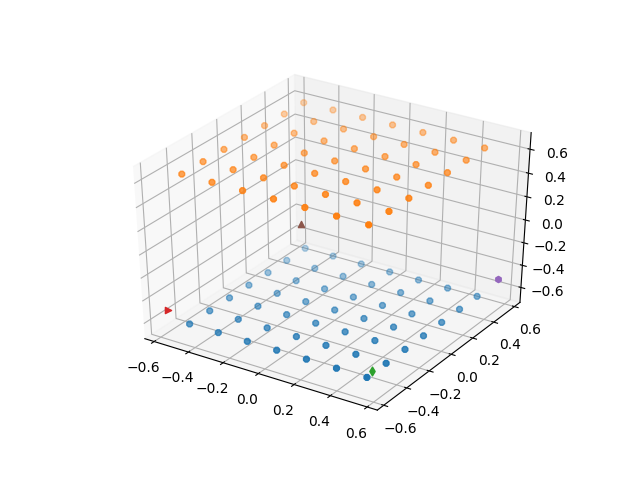

[(49,), (49,), (49,)]
[(49,), (49,), (49,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]
[(1,), (1,), (1,)]


In [279]:
def down_corners(size, l, r, t, d):
    tris = make_tris(size, l.device)
    lt = l[-size:,:,  :]
    tl = t[:size, :,  :] 

    ld = l[:size,:,  :] 
    dl = d[:size, :, :]

    tr = t[-size:, :,  :]
    rt = r[-size:,:, :] 

    rd = r[:size,:,  :]
    dr = d[-size:,:,  :]
    
    ltc = lt * tris['lt'] + tl * tris['tl']
    trc = tr * tris['tr'] + rt * tris['rt']
    ldc = ld * tris['ld'] + dl * tris['dl'] 
    drc = dr * tris['rd'] + rd * tris['dr']    
    return ltc, trc, ldc, drc


def get_corners(size, side_name, l, r, t, d):
    if side_name == 'front':
        return front_corners(size, l, r, t, d)
    elif side_name == 'back':
        return back_corners(size, l, r, t, d)
    elif side_name == 'left':
        return left_corners(size, l, r, t, d)
    elif side_name == 'right':
        return right_corners(size, l, r, t, d)
    elif side_name == 'top':
        return top_corners(size, l, r, t, d)
    elif side_name == 'down':
        return down_corners(size, l, r, t, d)
    raise Exception(f'Unknown side name {side_name}')
    
side_name = 'down'
kernel_size = 3
o = sides[side_name]
op = sides['top']
size = (kernel_size - 1) // 2
l, r, t, d = get_neighbors(sides, side_name, size)
print(shape(l, r, t, d ))

tris = make_tris(size, l.device)
lt = l[-size:,:,  :]
tl = t[:size, :,  :] 

ld = l[:size,:,  :] 
dl = d[:size, :, :]


tr = t[-size:, :,  :]
rt = r[-size:,:, :] 


rd = r[:size,:,  :]
dr = d[-size:,:,  :]

ltc = lt * tris['lt'] + tl * tris['tl']
trc = tr * tris['tr'] + rt * tris['rt']
ldc = ld * tris['ld'] + dl * tris['dl'] 
drc = dr * tris['rd'] + rd * tris['dr']

ltc, trc, ldc, drc = get_corners(size, side_name, l, r, t, d) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plot(ax, o, '8')
plot(ax, op, '8')

# plot(ax, l, 'v')
# plot(ax, r, 'p')
# plot(ax, t, 'P')
#plot(ax, d, 'X')



# plot(ax, lt, 'd')
# plot(ax, tl, 'd')
plot(ax, ltc, 'd')

# plot(ax, ld, '>')
# plot(ax, dl, '>')
plot(ax, ldc, '>')

# plot(ax, tr, 'h')
# plot(ax, rt, 'h')
plot(ax, trc, 'h')

# plot(ax, dr, '^')
# plot(ax, rd, '^')
plot(ax, drc, '^')